In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

In [2]:
df_ident = pd.read_csv('data/train_identity.csv.gz')
df_transact = pd.read_csv('data/train_transaction.csv.gz')

In [3]:
# Using TransactionID as index for both data.
df_ident.set_index('TransactionID',inplace=True)
df_transact.set_index('TransactionID',inplace=True)

In [4]:
if [ df_ident.index.is_unique & df_transact.index.is_unique]:
    print("Indexes of each Dataframe is unique")
if [df_ident[~df_ident.index.isin(df_transact.index)].count == 0]:
    print("Identity dataframe is a subset of transaction dataframe")

Indexes of each Dataframe is unique
Identity dataframe is a subset of transaction dataframe


In [5]:
category_thresh=0.001 #If a column has <0.1% of total as unique items it's a category
print('THRESHOLD TO BE CONSIDERED AS A CATEGORY: ' + str(category_thresh))
print('\n')
print('In any column if ' + str(category_thresh) + 'of non-null items')
print(' represent all the data then that data is considered to be categorical')
print(' and is encoded as a number for scikit learn to work')
print('\n')

for col in df_ident.columns:
    categ_ratio = df_ident[col].unique().size/df_ident[col].count()
    if df_ident[col].unique().size/df_ident[col].count() < category_thresh:
        print(col + ' seems to be a category')
        df_ident[col] = df_ident[col].astype('category').cat.codes
    else:
        print(col + ' not a category. Ratio: ' + str(categ_ratio))

for col in df_transact.columns:
    categ_ratio = df_transact[col].unique().size/df_transact[col].count()
    if categ_ratio < category_thresh:
        print(col + ' is a category. Ratio: ' + str(categ_ratio))
        df_transact[col] = df_transact[col].astype('category').cat.codes
    else:
        print(col + ' not a category. Ratio: ' + str(categ_ratio))

THRESHOLD TO BE CONSIDERED AS A CATEGORY: 0.001


In any column if 0.001of non-null items
 represent all the data then that data is considered to be categorical
 and is encoded as a number for scikit learn to work


id_01 seems to be a category
id_02 not a category. Ratio: 0.8210006246805611
id_03 seems to be a category
id_04 seems to be a category
id_05 seems to be a category
id_06 seems to be a category
id_07 not a category. Ratio: 0.016488845780795344
id_08 not a category. Ratio: 0.01842870999030068
id_09 seems to be a category
id_10 seems to be a category
id_11 not a category. Ratio: 0.002596149753862305
id_12 seems to be a category
id_13 seems to be a category
id_14 seems to be a category
id_15 seems to be a category
id_16 seems to be a category
id_17 seems to be a category
id_18 seems to be a category
id_19 not a category. Ratio: 0.0037540016365437347
id_20 not a category. Ratio: 0.002836400715203826
id_21 not a category. Ratio: 0.09517348323318472
id_22 not a category. Ratio: 0.

V82 is a category. Ratio: 1.7950599948940516e-05
V83 is a category. Ratio: 1.7950599948940516e-05
V84 is a category. Ratio: 1.7950599948940516e-05
V85 is a category. Ratio: 1.7950599948940516e-05
V86 is a category. Ratio: 6.382435537401073e-05
V87 is a category. Ratio: 6.382435537401073e-05
V88 is a category. Ratio: 5.983533316313505e-06
V89 is a category. Ratio: 7.978044421751341e-06
V90 is a category. Ratio: 1.3961577738064846e-05
V91 is a category. Ratio: 1.5956088843502682e-05
V92 is a category. Ratio: 1.7950599948940516e-05
V93 is a category. Ratio: 1.7950599948940516e-05
V94 is a category. Ratio: 7.978044421751341e-06
V95 not a category. Ratio: 0.0014943428449441401
V96 not a category. Ratio: 0.0023906096986578023
V97 not a category. Ratio: 0.0016552981400344952
V98 is a category. Ratio: 2.371972769752603e-05
V99 is a category. Ratio: 0.0001524839637698102
V100 is a category. Ratio: 5.082798792327007e-05
V101 not a category. Ratio: 0.001475705916038941
V102 not a category. Ratio:

V249 is a category. Ratio: 0.00018400674691405351
V250 is a category. Ratio: 0.00014142671267749053
V251 is a category. Ratio: 0.00014142671267749053
V252 is a category. Ratio: 0.00019934064249022465
V253 is a category. Ratio: 0.0005136855018017327
V254 is a category. Ratio: 0.0003526795982519359
V255 is a category. Ratio: 0.0003323527747921027
V256 is a category. Ratio: 0.0003464954460598518
V257 is a category. Ratio: 0.00038334738940427816
V258 is a category. Ratio: 0.0005213524495898183
V259 is a category. Ratio: 0.0004879221587373423
V260 is a category. Ratio: 7.666947788085564e-05
V261 is a category. Ratio: 0.0003220118070995937
V262 is a category. Ratio: 0.00016867285133788238
V263 not a category. Ratio: 0.07991259679521583
V264 not a category. Ratio: 0.10242275550103504
V265 not a category. Ratio: 0.09014797209231006
V266 not a category. Ratio: 0.01670627923023844
V267 not a category. Ratio: 0.027731350149505483
V268 not a category. Ratio: 0.0211377750517519
V269 not a category.

In [6]:
df_train = pd.merge(df_transact, df_ident, on='TransactionID', how='left')

In [7]:
df_train.head

<bound method NDFrame.head of                isFraud  TransactionDT  TransactionAmt  ProductCD  card1  \
TransactionID                                                             
2987000              0          86400          68.500          4  13926   
2987001              0          86401          29.000          4   2755   
2987002              0          86469          59.000          4   4663   
2987003              0          86499          50.000          4  18132   
2987004              0          86506          50.000          1   4497   
2987005              0          86510          49.000          4   5937   
2987006              0          86522         159.000          4  12308   
2987007              0          86529         422.500          4  12695   
2987008              0          86535          15.000          1   2803   
2987009              0          86536         117.000          4  17399   
2987010              0          86549          75.887          0  1649

# Data Prep

In [8]:
import re
def preprocessing(line):
    line = str(line).lower()
    line = re.sub(r"[^\w\s]", ' ', line)
    line = re.sub(r"\s+", ' ', line)
    return line

In [16]:
df_train['DeviceInfo'] = df_train['DeviceInfo'].apply(preprocessing)

In [19]:
#Change string values to numberical for scikit-learn to work
tfidf_vectorizer = TfidfVectorizer(preprocessor=preprocessing)
df_train['DeviceInfo'] = df_train['DeviceInfo'].apply(preprocessing)
tfidf = tfidf_vectorizer.fit_transform(df_train['DeviceInfo'].dropna())

#Cluster the devices in a randomly chosen number of groups.
num_types = 20
kmeans = KMeans(n_clusters=num_types).fit(tfidf)

#Cluster the items and get the 'labels'
device_code = kmeans.predict(tfidf_vectorizer.transform(df_train['DeviceInfo'].dropna()))

#We need replace the strings in DeviceInfo column with these numeric labels
dev_zip = dict(zip(df_train['DeviceInfo'].to_list(),device_code))
df_train['DeviceInfo'] = df_train['DeviceInfo'].fillna(-1).replace(dev_zip)

#And for other columns
num_types = 11
tfidf = tfidf_vectorizer.fit_transform(df_train['id_33'].dropna())
kmeans = KMeans(n_clusters=num_types).fit(tfidf)
resolution = kmeans.predict(tfidf_vectorizer.transform(df_train['id_33'].dropna()))
res_zip = dict(zip(df_train['id_33'].to_list(),resolution))
df_train['id_33'] = df_train['id_33'].fillna(-1).replace(res_zip)

nu_types = 10
tfidf = tfidf_vectorizer.fit_transform(df_train['id_31'].dropna())
kmeans = KMeans(n_clusters=num_types).fit(tfidf)
resolution = kmeans.predict(tfidf_vectorizer.transform(df_train['id_31'].dropna()))
res_zip = dict(zip(df_train['id_31'].to_list(),resolution))
df_train['id_31'] = df_train['id_31'].fillna(-1).replace(res_zip)


C:\Users\myneni\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:971: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (20). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\myneni\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:971: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (11). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\myneni\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:971: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (11). Possibly due to duplicate points in X.
  return_n_iter=True)


In [24]:
df_train['DeviceInfo']
df_train = df_train.fillna(-1)

In [25]:
X = df_train.drop('isFraud',axis=1)
y = df_train['isFraud']

In [26]:
print(X.DeviceInfo.dtype)

int32


In [27]:
# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state=42)

# Create the classifier: logreg
logreg = LogisticRegression()

# T R A I N
# Fit the classifier to the training data
logreg.fit(X_train,y_train)


C:\Users\myneni\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [28]:
# P R E D I C T
# Predict the labels of the test set: y_pred
y_pred = logreg.predict(X_test)

#
# E V A L U A T E
#
# Compute and print the confusion matrix and classification report
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


[[227820     62]
 [  8301     33]]
              precision    recall  f1-score   support

           0       0.96      1.00      0.98    227882
           1       0.35      0.00      0.01      8334

   micro avg       0.96      0.96      0.96    236216
   macro avg       0.66      0.50      0.49    236216
weighted avg       0.94      0.96      0.95    236216



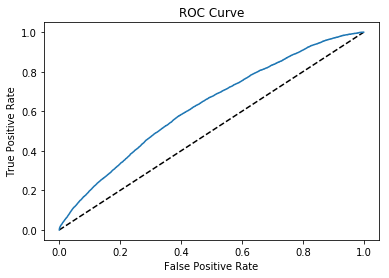

In [29]:
# R O C 
# Compute predicted probabilities: y_pred_prob
y_pred_prob = logreg.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()



In [ ]:
# A U C
# Compute predicted probabilities: y_pred_prob
y_pred_prob = logreg.predict_proba(X_test)[:,1]

# Compute and print AUC score
print("AUC: {}".format(roc_auc_score(y_test, y_pred_prob)))

# Compute cross-validated AUC scores: cv_auc
cv_auc = cross_val_score(logreg,X,y,scoring='roc_auc',cv=5)

# Print list of AUC scores
print("AUC scores computed using 5-fold cross-validation: {}".format(cv_auc))


AUC: 0.6252667991157823


C:\Users\myneni\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\myneni\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\myneni\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\myneni\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\myneni\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\